In [1]:
#
# phase4 :
#   Logistic regression Bayesian learning
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32,exception_verbosity=high"
import theano
import theano.tensor as T
import config
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [23]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models
import models.moon as moon
import seaborn as sns
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# parameter setup
reload( models.moon )
DIMX = 2
model = moon.Logistic(DIMX)
OUTPATH = '../report/figs/bayes/softmax'

data generated:
	x : (200, 2)
	y : (200,), 	values : [ 0.  1.]


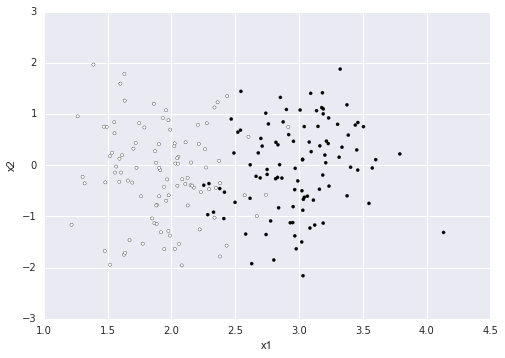

In [61]:
# data generation
reload(utils.plotZ)
SIZE = 400
S1 = int(SIZE*.25)
S2 = int(SIZE*.25)

blob_scale = np.asarray([3,1])
x1 = npr.randn( S1, DIMX )/blob_scale + np.asarray([3,0])
y1 = np.ones(S1)
x2 = npr.randn( S2, DIMX )/blob_scale + np.asarray([2,0])
y2 = np.zeros(S2)
x3 = npr.randn( S2, DIMX )/blob_scale + np.asarray([-2,0])
y3 = np.ones(S2)
x4 = npr.randn( S1, DIMX )/blob_scale + np.asarray([-3,0])
y4 = np.zeros(S1)

xn = np.concatenate([x1,x2],axis=0)
yn = np.concatenate([y1,y2],axis=0)
data = {'x':xn,'y':yn}
print ('data generated:\n\tx : %s\n\ty : %s, \tvalues : %s' %(data['x'].shape,data['y'].shape,np.unique(data['y'])))
fig = plotZ.category2d(data['x'],data['y'],dotarea=10)
plt.xlabel('x1')
plt.ylabel('x2')

In [63]:
# parameter setup
SAMPLINGNUM = 50
NUM_LAYERS = 8
DIMNF = 2
PRIOR_WEIGHT = 5
print('Variational model setup:\n\tnum-layers : %d\n\tdim : %d\n\tnum-sampling : %d'%(NUM_LAYERS,DIMNF,SAMPLINGNUM))

Variational model setup:
	num-layers : 8
	dim : 2
	num-sampling : 50


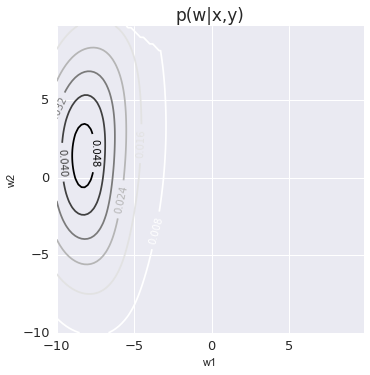

In [68]:
# plot true posterior

LOW,HIGH = -10,+10
GAP = (HIGH - LOW)/100.
gps, g1, g2 = mathZ.gridPoints( (LOW,HIGH,GAP), (LOW,HIGH,GAP) )

xname = 'w1'; yname = 'w2'
ws = gps
bs = np.zeros(ws.shape[0])  + 5

# xname = 'w1'; yname = 'b'
# w1s, bs = gps[:,0], gps[:,1]
# w2s = np.zeros(w1s.shape)-1
# ws = np.asarray([w1s,w2s]).T

logs_,logall= model.nlogPy_xw(data['x'],data['y'],ws,bs*5)
logs = logs_  + model.nlogPw(ws)*PRIOR_WEIGHT

logs = logs/SIZE
pws = logs.reshape(g1.shape[1],g2.shape[0]) 
pws = np.exp(pws)
fig = plt.figure()
CS = plt.contour(g1,g2,pws)
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.xlabel(xname); plt.ylabel(yname)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('p(w|x,y)', fontsize=17)
plt.show()

In [9]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIMNF, numlayers=NUM_LAYERS,noisestd=1.)  
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)                 # z = L * ( DIMNF )

# matching latent variables to parameters
wt = z.reshape((SAMPLINGNUM,DIMNF))
bt = utils.theanoGeneral.sharedf([0]*SAMPLINGNUM)

print('TensorVariable setup,\n\twt, (L,dimx) %s\n\tbt, (L ,   ) %s\n\tz , (L,dimx) %s\n\tlogqz,       %s' 
      % (wt.shape.eval(), bt.shape.eval(), z.shape.eval(), logqz.shape.eval()) )

TensorVariable setup,
	wt, (L,dimx) [50  2]
	bt, (L ,   ) [50]
	z , (L,dimx) [50  2]
	logqz,       [50]


In [10]:
# setting cost variable
x = utils.theanoGeneral.sharedf(data['x'])
y = utils.theanoGeneral.sharedf(data['y'])

logpy_xw, temp = model.logPy_xw(x,y,wt,bt)
logpw = model.logPw(wt)
print ('data input:\n\tx : %s\n\ty : %s'%(x.shape.eval(),y.shape.eval()))
print ('model densities:\n\tlog( p(y|x,w) ) : %s\n\tlog( p(w) )     : %s'
       %(logpy_xw.shape.eval(),logpw.shape.eval()))

data input:
	x : [160   2]
	y : [160]
model densities:
	log( p(y|x,w) ) : [50]
	log( p(w) )     : [50]


In [11]:
# ELBO
logpxyw = (logpy_xw + logpw*PRIOR_WEIGHT)/SIZE
cost = T.mean( logqz - logpxyw )  # negative-ELBO

In [12]:
# gradients reading
params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [13]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.03,momentum=0.6,decay=0.0005)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpxyw), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [14]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [15]:
# training
NUMITER = 1000
keys = ['cost','pxz','qz']
record = {}

# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    out = estep()
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

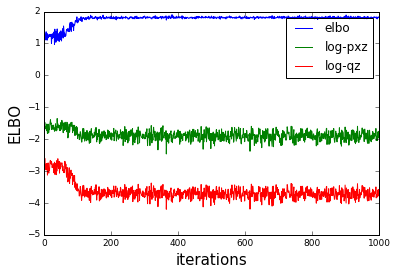

In [16]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='elbo')
plt.xlabel('iterations',fontsize=15)
plt.ylabel('ELBO',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig(OUTPATH+'/elbo_L%d.png'%(NUM_LAYERS))

plt.plot( xs, record['pxz'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')

plt.legend()
plt.show()

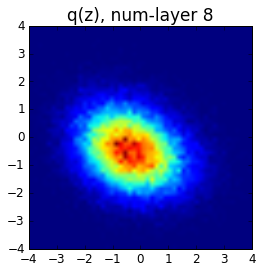

In [22]:
# estimated posterior
xlims = (-4,+4)
ylims = (-4,+4)
es, zs = fez2()
AXES = (0,1)
heatmap, xedges, yedges = np.histogram2d( zs[:,AXES[0]], zs[:,AXES[1]], bins=50)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
extent = [xlims[0], xlims[1], ylims[0], ylims[1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlim(xlims)
plt.ylim(ylims)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('q(z), num-layer %d' % (NUM_LAYERS), fontsize=17)
plt.savefig( OUTPATH+'/dist_L%d_iter%d.png'%(NUM_LAYERS,NUMITER))